=== Classification Report ===
              precision    recall  f1-score   support

        Down       0.81      0.62      0.70       396
          Up       0.76      0.89      0.82       521

    accuracy                           0.77       917
   macro avg       0.78      0.75      0.76       917
weighted avg       0.78      0.77      0.77       917

=== Confusion Matrix ===
[[246 150]
 [ 58 463]]

=== Profitability by Confidence Threshold ===

Threshold: 0.50 | Final: $1,054.55 | Net P/L: $54.55 | Trades: 613 | Avg Gain: 0.0183 | Avg Loss: -0.0189
Threshold: 0.60 | Final: $898.01 | Net P/L: $-101.99 | Trades: 460 | Avg Gain: 0.0178 | Avg Loss: -0.0196
Threshold: 0.70 | Final: $881.61 | Net P/L: $-118.39 | Trades: 300 | Avg Gain: 0.0176 | Avg Loss: -0.0186
Threshold: 0.80 | Final: $1,031.49 | Net P/L: $31.49 | Trades: 102 | Avg Gain: 0.0207 | Avg Loss: -0.0170
Threshold: 0.85 | Final: $745.48 | Net P/L: $-254.52 | Trades: 40 | Avg Gain: 0.0149 | Avg Loss: -0.0231
Threshold: 0.90 | 

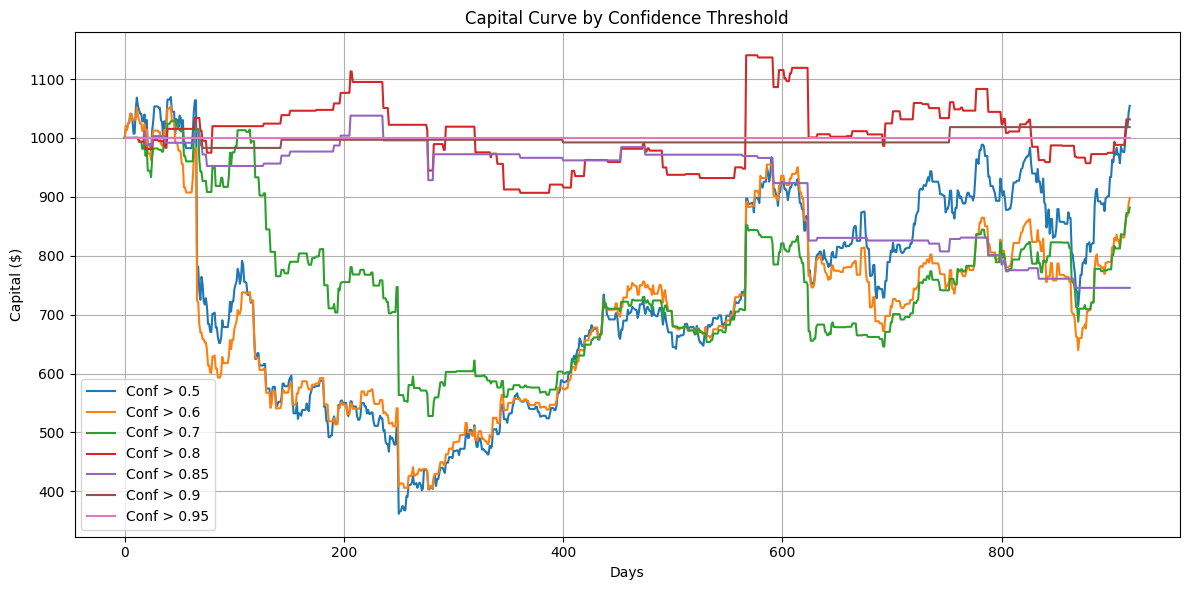

In [4]:
import yfinance as yf
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# 1) Load ticker data
def load_ticker_windows(ticker, seq_len=30):
    file_path = f"{ticker}_daily_2018-2025.csv"
    if not os.path.exists(file_path):
        df = yf.download(ticker, start="2018-01-01", end="2025-06-30", interval="1d", auto_adjust=True)
        df.to_csv(file_path)
    else:
        df = pd.read_csv(file_path, index_col=0)

    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(0)

    numeric_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
    for col in numeric_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    df.dropna(inplace=True)

    df['log_ret'] = np.log(df['Close'] / df['Close'].shift(1))

    delta = df['Close'].diff()
    up = delta.clip(lower=0)
    down = -delta.clip(upper=0)
    roll_up = up.rolling(14).mean()
    roll_down = down.rolling(14).mean()
    RS = roll_up / roll_down
    df['RSI'] = 100.0 - (100.0 / (1.0 + RS))

    ema12 = df['Close'].ewm(span=12, adjust=False).mean()
    ema26 = df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = ema12 - ema26
    df['BB_MID'] = df['Close'].rolling(20).mean()
    df['BB_STD'] = df['Close'].rolling(20).std()
    df['BB_UP'] = df['BB_MID'] + 2 * df['BB_STD']
    df['BB_DOWN'] = df['BB_MID'] - 2 * df['BB_STD']
    df['ATR'] = (df['High'] - df['Low']).rolling(14).mean()

    df.dropna(inplace=True)

    future_ret = df['log_ret'].rolling(5).sum().shift(-5)
    df['target'] = (future_ret > 0).astype(int)

    features = ['Open', 'High', 'Low', 'Close', 'Volume', 'RSI', 'MACD', 'BB_UP', 'BB_DOWN', 'ATR']
    mats, y, dates = [], [], []

    for i in range(seq_len, len(df)):
        mat = df.iloc[i-seq_len:i][features].values
        # No normalization here, just flatten
        mats.append(mat.T.flatten())
        y.append(df['target'].iloc[i])
        dates.append(df.index[i])

    return np.stack(mats), np.array(y), df.iloc[seq_len:].reset_index()

# 2) Load all tickers
X_all, y_all, df_all_list = [], [], []
for ticker in ["AAPL", "MSFT", "GOOG", "AMZN", "META"]:
    X, y, df = load_ticker_windows(ticker)
    X_all.append(X)
    y_all.append(y)
    df_all_list.append(df)

X_all = np.concatenate(X_all)
y_all = np.concatenate(y_all)
df_all = pd.concat(df_all_list).reset_index(drop=True)

# 3) Train-test split (with shuffle)
X_train, X_temp, y_train, y_temp = train_test_split(X_all, y_all, test_size=0.2, random_state=42, stratify=y_all, shuffle=True)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp, shuffle=True)

# 4) Train Random Forest without normalization
rf = RandomForestClassifier(
    n_estimators=300,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

# 5) Evaluate
y_pred = rf.predict(X_test)
print("=== Classification Report ===")
print(classification_report(y_test, y_pred, target_names=["Down", "Up"]))
print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, y_pred))

# 6) Capital simulation across thresholds
probs = rf.predict_proba(X_test)
confidences = np.max(probs, axis=1)
y_pred_conf = np.argmax(probs, axis=1)

returns = np.exp(df_all['log_ret'].values) - 1
test_returns = returns[-len(y_pred_conf):]
initial_capital = 1000.0

thresholds = [0.5, 0.6, 0.7, 0.8, 0.85, 0.9, 0.95]
results = []

plt.figure(figsize=(12, 6))
for thresh in thresholds:
    capital = initial_capital
    capital_curve = [capital]
    trade_count = 0
    profit_trades, loss_trades = [], []

    for ret, pred, conf in zip(test_returns, y_pred_conf, confidences):
        if pred == 1 and conf > thresh:
            trade_count += 1
            capital *= (1 + ret)
            (profit_trades if ret >= 0 else loss_trades).append(ret)
        capital_curve.append(capital)

    results.append({
        'threshold': thresh,
        'final_capital': capital,
        'net_PL': capital - initial_capital,
        'total_trades': trade_count,
        'avg_gain': np.mean(profit_trades) if profit_trades else 0,
        'avg_loss': np.mean(loss_trades) if loss_trades else 0,
    })

    plt.plot(capital_curve, label=f"Conf > {thresh}")

# 7) Summary print
print("\n=== Profitability by Confidence Threshold ===\n")
for r in results:
    print(f"Threshold: {r['threshold']:.2f} | Final: ${r['final_capital']:,.2f} | "
          f"Net P/L: ${r['net_PL']:,.2f} | Trades: {r['total_trades']} | "
          f"Avg Gain: {r['avg_gain']:.4f} | Avg Loss: {r['avg_loss']:.4f}")

# 8) Plot
plt.title("Capital Curve by Confidence Threshold")
plt.xlabel("Days")
plt.ylabel("Capital ($)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
